In [1]:
import torch
from torch.autograd import Variable
import numpy as np

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
import time

import model
from loss import GANLoss
import util

# LR image size
imageSize = 32
# upSampling from LR image to HR image
upSampling = 4
batchSize = 16
total_epochs = 331 # total_epochs * n_batches = n_updates
val_freq = 30 # Validation frequency. Every x epochs
workers = 0
dataroot = './HR_data'
valroot = './Val_data'
feature_layer = 34 # VGG Feature layer for computing perception loss
pretrain_with_psnr = 0 # Use ESRGAN network trained for psnr as initialization for generator?

# Learning rates and optimizer parameters
beta1 = 0.9
beta2 = 0.999
# G
lr_G = 1e-4
wd_G = 0 # Weight Decay
lmbda = 5e-3
eta = 1e-2
# D
lr_D = 1e-4
wd_D = 0


# random crop for HR images with fixed size
transform = transforms.Compose([transforms.RandomCrop(imageSize*upSampling), transforms.ToTensor()])

# normalize the images
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# unnormalize the images
unnormalize = transforms.Normalize(mean = [-2.118, -2.036, -1.804], std = [4.367, 4.464, 4.444])

# produce LR images from HR images
scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                            ])

dataset = datasets.ImageFolder(root=dataroot, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

low_res = torch.FloatTensor(batchSize, 3, imageSize, imageSize)

# Validation
val_scale = transforms.Compose([transforms.ToPILImage(),
                                transforms.Scale(imageSize),
                                transforms.ToTensor()
                               ])
val_dataset = datasets.ImageFolder(root=valroot, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1)
val_psnr = []
val_epoch = []

# Generator
netG = model.RRDB_Net(3, 3, 64, 23, gc=32, upscale=4, norm_type=None, act_type='leakyrelu', res_scale=1)
if pretrain_with_psnr:
    netG.load_state_dict(torch.load('SavedNetworks/RRDB_PSNR_x4.pth'), strict=True)

# Discriminator
netD = model.Discriminator_VGG_128(3, 64, norm_type='batch', act_type='leakyrelu')
# FeatureExtractor
netF = model.VGGFeatureExtractor(feature_layer=feature_layer, use_bn=False, use_input_norm=True)

device = torch.device('cuda')

netG = netG.to(device)
netD = netD.to(device)
netF = netF.to(device)

# Optimizers
# G
optim_params = []
for k, v in netG.named_parameters():  # can optimize for a part of the model
    if v.requires_grad:
        optim_params.append(v)
    else:
        print('WARNING: params [{:s}] will not optimize.'.format(k))
optimizer_G = torch.optim.Adam(optim_params, lr=lr_G, weight_decay=wd_G, betas=(beta1, beta2))

# D
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr_D, weight_decay=wd_D, betas=(beta1, beta2))

# Loss functions
cri_gan = GANLoss()
cri_pix = torch.nn.L1Loss()
cri_fea = torch.nn.L1Loss()

cri_gan = cri_gan.to(device)
cri_pix = cri_pix.to(device)
cri_fea = cri_fea.to(device)

loss_G_epoch = []
loss_D_epoch = []


print('Start training')
for epoch in range(total_epochs):
    for i, data in enumerate(dataloader):
        high_res_real, _ = data
        
        # Downsample images to low resolution
        for j in range(batchSize):
            low_res[j] = val_scale(high_res_real[j])
#             high_res_real[j] = normalize(high_res_real[j])

        # Generator
        for p in netD.parameters():
            p.requires_grad = False

        optimizer_G.zero_grad()

        high_res_real = Variable(high_res_real.cuda())
        high_res_fake = netG(Variable(low_res).cuda())

        l_g_total = 0

        # L1Loss
        l_g_pix = eta * (cri_pix(high_res_fake, high_res_real))

        l_g_total += l_g_pix

        # Feature loss
        real_fea = netF(high_res_real).detach()
        fake_fea = netF(high_res_fake)
        l_g_fea = cri_fea(fake_fea, real_fea)

        l_g_total += l_g_fea

        # Relativistic GAN Loss
        pred_g_fake = netD(high_res_fake)
        pred_d_real = netD(high_res_real).detach()

        # cri_gan gives error
        l_g_gan = lmbda * (cri_gan(pred_d_real - torch.mean(pred_g_fake), False) +
                            cri_gan(pred_g_fake - torch.mean(pred_d_real), True)) / 2
        l_g_total += l_g_gan


        # Backpropagation and update
        l_g_total.backward()
        optimizer_G.step()

        # Discriminator
        for p in netD.parameters():
            p.requires_grad = True

        optimizer_D.zero_grad()
        l_d_total = 0
        pred_d_real = netD(high_res_real)
        pred_d_fake = netD(high_res_fake.detach())  # detach to avoid BP to G
        l_d_real = cri_gan(pred_d_real - torch.mean(pred_d_fake), True)
        l_d_fake = cri_gan(pred_d_fake - torch.mean(pred_d_real), False)

        l_d_total = (l_d_real + l_d_fake) / 2

        l_d_total.backward()
        optimizer_D.step()
        
        # Keep track of losses
        loss_G_epoch.append(l_g_total)
        loss_D_epoch.append(l_d_total)
    
#     print(epoch, n_minibatches)
    if epoch % val_freq == 0:
        avg_psnr = 0.0
        idx = 0
        for val_data in val_loader:
            idx += 1
            val_hr_real, _ = val_data
            val_lr = val_scale(val_hr_real[0])
            
            val_hr_real = Variable(val_hr_real.cuda())
            
            netG.eval()
            
            with torch.no_grad():
                val_hr_fake = netG(Variable(val_lr).unsqueeze(0).cuda()) # Unsqueeze bc minibatch size=1 not 16.
            
            sr_img = util.tensor2img( val_hr_fake.detach()[0].float().cpu() )
            hr_img = util.tensor2img( val_hr_real.detach()[0].float().cpu() )
            
            avg_psnr += util.calculate_psnr(sr_img, hr_img)
            
            netG.train()
            
        avg_psnr = avg_psnr / idx
        val_psnr.append(avg_psnr)
        val_epoch.append(epoch)
        print(epoch, avg_psnr)
        if pretrain_with_psnr:
            torch.save(netG, 'SavedNetworks/Generator_pretrained_psnr.pth')
            torch.save(netD, 'SavedNetworks/Discriminator_pretrained_psnr.pth')
        else:
            torch.save(netG, 'SavedNetworks/Generator_from_scratch.pth')
            torch.save(netD, 'SavedNetworks/Discriminator_from_scratch.pth')
#         print(epoch)

if pretrain_with_psnr:
    torch.save(netG, 'SavedNetworks/Generator_pretrained_psnr.pth')
    torch.save(netD, 'SavedNetworks/Discriminator_pretrained_psnr.pth')
    np.save('val_psnr_pretrained.npy', np.vstack((val_epoch, val_psnr)))
else:
    torch.save(netG, 'SavedNetworks/Generator_from_scratch.pth')
    torch.save(netD, 'SavedNetworks/Discriminator_from_scratch.pth')
    np.save('val_psnr_scratch.npy', np.vstack((val_epoch, val_psnr)))
print('End training')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


Start training
0 14.787311573027221
30 22.680572004034214
60 22.800054391816577
90 22.805138826193588
120 21.86809063583698
150 20.972362974183238
180 22.442192588703023
210 21.68454355775738
240 20.961222839097577
270 21.861990913117822
300 22.32630049572504


NameError: name 'np' is not defined

(128, 128, 3)


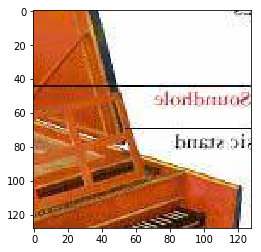

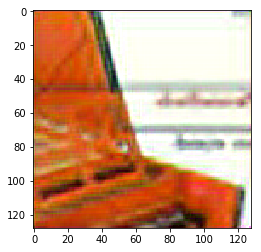

tensor(1.2345, device='cuda:0')
tensor(1.00000e-04 *
       1.4363, device='cuda:0')


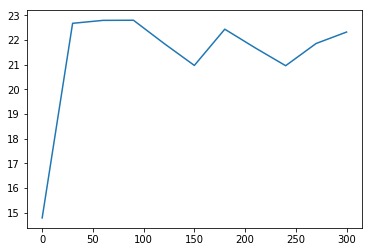

In [6]:
import matplotlib.pyplot as plt
print(hr_img.shape)
hr = np.transpose(hr_img[:, :, [2, 1, 0]], (0, 1, 2))
sr = np.transpose(sr_img[:, :, [2, 1, 0]], (0, 1, 2))
plt.figure()
plt.imshow(hr)
plt.figure()
plt.imshow(sr)
plt.show()
print(l_g_total)
print(l_d_total)
psnr = np.load('val_psnr_scratch.npy')
plt.figure()
plt.plot(psnr[0,:], psnr[1,:])

In [93]:
# display original HR image
img = to_pil(unnormalize(high_res_real.data[-1]))

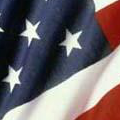

In [94]:
img

In [95]:
# display downsampled LR image
img = to_pil(unnormalize(low_res[-1]))

In [96]:
img

0
3
6
9
